# R-Anode Gravitational Wave Demo

Generate toy gravitational wave background and signal events

Preprocess and split the data into sidebands (control) and signal regions

Train the background density estimator (normalizing flow)

Train the residual signal flow with a fixed signal fraction hypothesis

Evaluate the learned anomaly score on a held-out sample


All heavy Luigi/Law orchestration is skipped so the core R-Anode logic can be inspected interactively.

Using project root: /Users/krishwu/code/GBI/ranode
Using device: mps


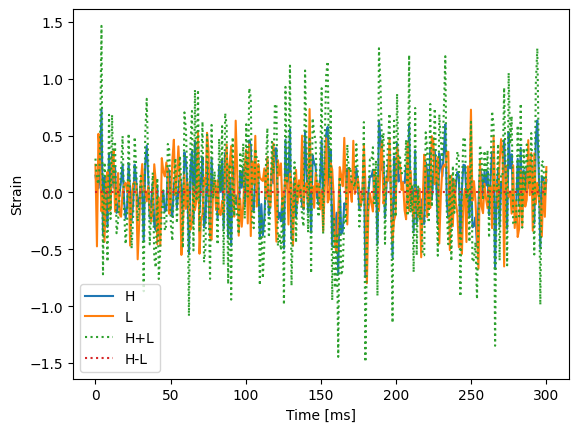

In [1]:
import os
import sys
import copy
import json
import pathlib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ensure project root (with 'config/' and 'src/') is on sys.path
project_root = pathlib.Path.cwd().resolve()
if not (project_root / "config").exists():
    candidate = project_root.parent
    if (candidate / "config").exists():
        project_root = candidate
if (project_root / "config").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Using project root: {project_root}")

from config import configs
from src.data_prep.gw_processing import process_gw_backgrounds, process_gw_signals, gw_background_split
from src.data_prep.utils import preprocess_params_fit, logit_transform, standardize, inverse_transform
from src.models.model_B import DensityEstimator, anode
from src.models.model_S import flows_model_RQS, r_anode_mass_joint_untransformed
from scipy.stats import rv_histogram

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "mps":
    torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float32)

torch.manual_seed(42)


In [2]:
SIGNAL_AMPLITUDE = 120.0  # tweak amplitude to study sensitivity

raw_bkg = process_gw_backgrounds()
raw_sig = process_gw_signals(amplitude=SIGNAL_AMPLITUDE)

def combine_signal_with_background(background: np.ndarray, signal: np.ndarray, scale: float = 1.0) -> np.ndarray:
    if background.shape != signal.shape:
        raise ValueError("Signal and background must share identical shape")
    combined = background.copy()
    if not np.allclose(background[:, 0], signal[:, 0], atol=1e-8):
        raise ValueError("Time grids for signal and background do not align")
    combined[:, 1] = background[:, 1] + scale * signal[:, 1]
    combined[:, 2] = background[:, 2] + scale * signal[:, 2]
    combined[:, 3] = combined[:, 1] + combined[:, 2]
    combined[:, 4] = combined[:, 1] - combined[:, 2]
    combined[:, -1] = 1.0
    return combined

combined_signal_raw = combine_signal_with_background(raw_bkg, raw_sig)
assert np.allclose(combined_signal_raw[:, 0], raw_bkg[:, 0])
assert np.allclose(combined_signal_raw[:, 1] - raw_bkg[:, 1], raw_sig[:, 1])
assert np.allclose(combined_signal_raw[:, 2] - raw_bkg[:, 2], raw_sig[:, 2])
assert np.allclose(combined_signal_raw[:, 3], combined_signal_raw[:, 1] + combined_signal_raw[:, 2])
assert np.allclose(combined_signal_raw[:, 4], combined_signal_raw[:, 1] - combined_signal_raw[:, 2])
print("Verified: signal is added sample-wise to the background")

print(f"Background shape: {raw_bkg.shape}")
print(f"Signal template shape: {raw_sig.shape}")
print(f"Signal+background combined shape: {combined_signal_raw.shape}")
print("Columns: [time, H, L, H+L, H-L, label]")


Verified: signal is added sample-wise to the background
Background shape: (300, 6)
Signal template shape: (300, 6)
Signal+background combined shape: (300, 6)
Columns: [time, H, L, H+L, H-L, label]


GW Background split: Inner=150, Outer=150
GW Background split: Inner=150, Outer=150
Pre_params: {'min': array([-2.82868855, -2.85103754, -4.27016915, -3.97361998]), 'max': array([2.60501322, 2.87029626, 4.00987386, 4.16939035]), 'mean': array([ 0.13861957, -0.03983478,  0.06631524, -0.05850902]), 'std': array([0.94898756, 0.94649879, 0.90645643, 0.8041287 ])}
Control-region processed shape: (150, 6)
Signal-region background shape: (150, 6)
Signal-region injected signal shape: (150, 6)


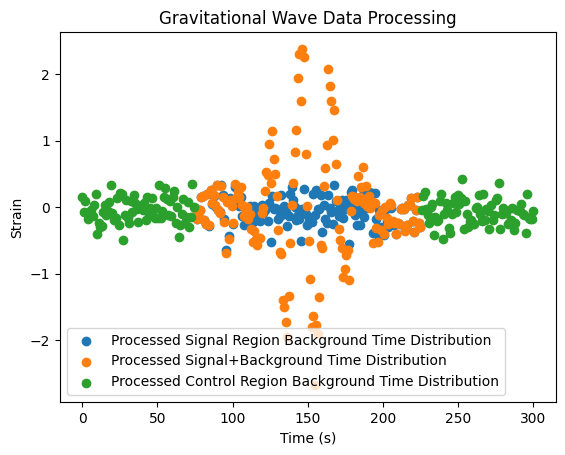

In [3]:
# --- split background into signal/control regions and fit preprocessing ---
SR_bkg_raw, CR_bkg_raw = gw_background_split(raw_bkg, resample_seed=42)
# I am instead basing the preprocessing params on the signal region. IMPORTANT NOTE for KRISH
# pre_params = preprocess_params_fit(CR_bkg_raw)
SR_sig_raw, CR_sig_raw = gw_background_split(combined_signal_raw, resample_seed=42)
pre_params = preprocess_params_fit(SR_sig_raw)
feature_min = pre_params["min"]
feature_max = pre_params["max"]
feature_range = feature_max - feature_min
buffer = np.maximum(feature_range * 0.1, 1e-3)
pre_params["min"] = feature_min - buffer
pre_params["max"] = feature_max + buffer
print("Pre_params:", pre_params)

def transform_with_params(data, params, clip_eps=1e-6):
    feature_min = params["min"]
    feature_max = params["max"]
    feature_mean = params["mean"]
    feature_std = params["std"]

    denom = feature_max - feature_min
    denom = np.where(denom == 0, 1e-6, denom)
    x = data[:, 1:-1]
    x_norm = (x - feature_min) / denom
    x_norm = np.clip(x_norm, clip_eps, 1 - clip_eps)
    logit = np.log(x_norm / (1 - x_norm))
    mask = np.isfinite(logit).all(axis=1)

    transformed = np.hstack([data[:, 0:1], logit, data[:, -1:]])[mask]
    transformed[:, 1:-1] = standardize(transformed[:, 1:-1], feature_mean, feature_std)
    return transformed, data[mask]

CR_processed, CR_aligned_raw = transform_with_params(CR_bkg_raw, pre_params)
SR_bkg_processed, SR_bkg_aligned_raw = transform_with_params(SR_bkg_raw, pre_params)
SR_sig_processed, SR_sig_aligned_raw = transform_with_params(SR_sig_raw, pre_params)

print(f"Control-region processed shape: {CR_processed.shape}")
print(f"Signal-region background shape: {SR_bkg_processed.shape}")
print(f"Signal-region injected signal shape: {SR_sig_processed.shape}")

# Build background mass/time PDF for later mixing
hist_counts, hist_bins = np.histogram(SR_bkg_aligned_raw[:, 0], bins=40, density=True)
mass_density = rv_histogram((hist_counts, hist_bins))

plt.clf()
# plt.scatter(SR_bkg_raw[:, 0], SR_bkg_raw[:, 1], label='Signal Region Background Time Distribution')
# plt.scatter(CR_bkg_raw[:, 0], CR_bkg_raw[:, 1], label='Control Region Background Time Distribution')
plt.scatter(SR_bkg_processed[:, 0], SR_bkg_processed[:, 1], label='Processed Signal Region Background Time Distribution')
plt.scatter(SR_sig_processed[:, 0], SR_sig_processed[:, 1], label='Processed Signal+Background Time Distribution')
# plt.scatter(CR_sig_raw[:, 0], CR_sig_raw[:, 1], label='Signal Region Raw Signal+Background Time Distribution')
plt.scatter(CR_processed[:, 0], CR_processed[:, 1], label='Processed Control Region Background Time Distribution')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.title('Gravitational Wave Data Processing')
plt.show()

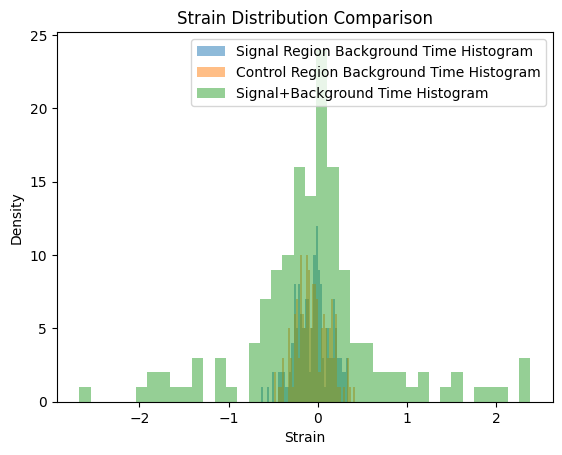

In [4]:
plt.clf()
plt.hist(SR_bkg_processed[:, 1], bins=40, alpha=0.5, label='Signal Region Background Time Histogram')
plt.hist(CR_processed[:, 1], bins=40, alpha=0.5, label='Control Region Background Time Histogram')
plt.hist(SR_sig_processed[:, 1], bins=40, alpha=0.5, label='Signal+Background Time Histogram')
plt.xlabel('Strain')
plt.ylabel('Density')
plt.legend()
plt.title('Strain Distribution Comparison')
plt.show()

In [5]:
# --- train the background normalizing flow on CR data ---
CR_train, CR_val = train_test_split(CR_processed, test_size=0.25, random_state=42, shuffle=True)

train_tensor = torch.from_numpy(CR_train.astype("float32")).to(device)
val_tensor = torch.from_numpy(CR_val.astype("float32")).to(device)

train_loader = DataLoader(TensorDataset(train_tensor), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=1024, shuffle=False)

config_path = project_root / "src" / "models" / "DE_MAF_model.yml"
model_B = DensityEstimator(str(config_path), eval_mode=False, device=device)

bkg_train_losses = []
bkg_val_losses = []
best_state = None
best_val = float("inf")
patience = 0
PATIENCE_LIMIT = 5
EPOCHS_BKG = 200

for epoch in range(1, EPOCHS_BKG + 1):
    train_loss = anode(model_B.model, train_loader, model_B.optimizer, params=None, device=device, mode="train")
    val_loss = anode(model_B.model, val_loader, model_B.optimizer, params=None, device=device, mode="val")
    bkg_train_losses.append(float(train_loss))
    bkg_val_losses.append(float(val_loss))
    print(f"[Bkg] Epoch {epoch:02d} | train: {train_loss:.4f} | val: {val_loss:.4f}")
    if val_loss < best_val - 1e-4:
        best_val = val_loss
        best_state = copy.deepcopy({k: v.cpu() for k, v in model_B.model.state_dict().items()})
        patience = 0
    else:
        patience += 1
        if patience >= PATIENCE_LIMIT:
            print("Stopping early (background model)")
            break

if best_state is not None:
    model_B.model.load_state_dict(best_state)
model_B.model.to(device)
model_B.model.eval()


DensityEstimator has 274800 parameters
setting batch norm layers to eval mode
[Bkg] Epoch 01 | train: 123.2614 | val: 118.0208
setting batch norm layers to eval mode
[Bkg] Epoch 02 | train: 116.0288 | val: 109.2148
setting batch norm layers to eval mode
[Bkg] Epoch 03 | train: 107.3324 | val: 103.8103
setting batch norm layers to eval mode
[Bkg] Epoch 04 | train: 102.0509 | val: 95.9450
setting batch norm layers to eval mode
[Bkg] Epoch 05 | train: 94.2416 | val: 90.9062
setting batch norm layers to eval mode
[Bkg] Epoch 06 | train: 89.3228 | val: 85.2633
setting batch norm layers to eval mode
[Bkg] Epoch 07 | train: 83.7958 | val: 78.4685
setting batch norm layers to eval mode
[Bkg] Epoch 08 | train: 76.9818 | val: 75.3892
setting batch norm layers to eval mode
[Bkg] Epoch 09 | train: 73.8525 | val: 71.2282
setting batch norm layers to eval mode
[Bkg] Epoch 10 | train: 69.7399 | val: 65.6242
setting batch norm layers to eval mode
[Bkg] Epoch 11 | train: 64.2847 | val: 64.9486
setting 

FlowSequential(
  (0): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (cond_linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (1): BatchNormFlow()
  (2): Reverse()
  (3): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (cond_linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=128, out_features=8, bias=True)
      )
    )
  )
  (4): BatchNorm

In [6]:
# --- prepare signal-region datasets & background log probabilities ---
SR_combined_processed = np.vstack([SR_bkg_processed, SR_sig_processed])
SR_combined_raw = np.vstack([SR_bkg_aligned_raw, SR_sig_aligned_raw])

indices = np.arange(len(SR_combined_processed))
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=1337,
    stratify=SR_combined_processed[:, -1],
)

SR_train_all = SR_combined_processed[train_idx]
SR_train_raw_all = SR_combined_raw[train_idx]
SR_test = SR_combined_processed[test_idx]
SR_test_raw = SR_combined_raw[test_idx]

with torch.no_grad():
    train_tensor_all = torch.from_numpy(SR_train_all.astype("float32")).to(device)
    log_B_train_all = model_B.model.log_probs(
        inputs=train_tensor_all[:, 1:-1],
        cond_inputs=train_tensor_all[:, 0:1],
    ).cpu().numpy()

    test_tensor = torch.from_numpy(SR_test.astype("float32")).to(device)
    log_B_test = model_B.model.log_probs(
        inputs=test_tensor[:, 1:-1],
        cond_inputs=test_tensor[:, 0:1],
    ).cpu().numpy()

mass_pdf_train_all = mass_density.pdf(SR_train_raw_all[:, 0])
mass_pdf_test = mass_density.pdf(SR_test_raw[:, 0])

# split train into (train, val)
inner_indices = np.arange(len(SR_train_all))
train_inner_idx, val_inner_idx = train_test_split(
    inner_indices,
    test_size=0.2,
    random_state=2024,
    stratify=SR_train_all[:, -1],
)

SR_train = SR_train_all[train_inner_idx]
SR_val = SR_train_all[val_inner_idx]
SR_train_raw = SR_train_raw_all[train_inner_idx]
SR_val_raw = SR_train_raw_all[val_inner_idx]

log_B_train = log_B_train_all[train_inner_idx]
log_B_val = log_B_train_all[val_inner_idx]

mass_pdf_train = mass_pdf_train_all[train_inner_idx]
mass_pdf_val = mass_pdf_train_all[val_inner_idx]

center_time = 0.5 * (configs.SR_MIN + configs.SR_MAX)
def shift_time(data):
    shifted = data.copy()
    shifted[:, 0] -= center_time
    return shifted

SR_train_shifted = shift_time(SR_train)
SR_val_shifted = shift_time(SR_val)
SR_test_shifted = shift_time(SR_test)
SR_sig_shifted = shift_time(SR_sig_processed)

signal_fraction = float(SR_train[:, -1].mean())
print(f"Training signal fraction w ≈ {signal_fraction:.4f}")

Training signal fraction w ≈ 0.5000


In [7]:
# --- train the residual signal flow ---
train_dataset = TensorDataset(
    torch.from_numpy(SR_train_shifted.astype("float32")).to(device),
    torch.from_numpy(log_B_train.astype("float32")).to(device),
    torch.from_numpy(mass_pdf_train.astype("float32")).to(device),
)
val_dataset = TensorDataset(
    torch.from_numpy(SR_val_shifted.astype("float32")).to(device),
    torch.from_numpy(log_B_val.astype("float32")).to(device),
    torch.from_numpy(mass_pdf_val.astype("float32")).to(device),
)

train_loader_S = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader_S = DataLoader(val_dataset, batch_size=512, shuffle=False)

model_S = flows_model_RQS(
    num_layers=4,
    num_features=4,
    num_blocks=2,
    hidden_features=64,
    device=device,
    context_features=1,
)

optimizer_S = torch.optim.AdamW(model_S.parameters(), lr=3e-4)
scheduler_S = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_S, T_0=10, T_mult=2)

sig_train_losses = []
sig_val_losses = []
best_state_S = None
best_val_S = float("inf")
patience_S = 0
PATIENCE_LIMIT_S = 8
EPOCHS_SIG = 200

for epoch in range(1, EPOCHS_SIG + 1):
    train_loss = r_anode_mass_joint_untransformed(
        model_S=model_S,
        w=signal_fraction,
        optimizer=optimizer_S,
        data_loader=train_loader_S,
        device=device,
        mode="train",
        scheduler=scheduler_S,
    )
    val_loss = r_anode_mass_joint_untransformed(
        model_S=model_S,
        w=signal_fraction,
        optimizer=optimizer_S,
        data_loader=val_loader_S,
        device=device,
        mode="val",
    )
    sig_train_losses.append(float(train_loss))
    sig_val_losses.append(float(val_loss))
    print(f"[Signal] Epoch {epoch:02d} | train: {train_loss:.4f} | val: {val_loss:.4f}")
    if val_loss < best_val_S - 1e-4:
        best_val_S = val_loss
        best_state_S = copy.deepcopy({k: v.cpu() for k, v in model_S.state_dict().items()})
        patience_S = 0
    else:
        patience_S += 1
        if patience_S >= PATIENCE_LIMIT_S:
            print("Stopping early (signal model)")
            break
    scheduler_S.step()

if best_state_S is not None:
    model_S.load_state_dict(best_state_S)
model_S.to(device)
model_S.eval()


value of w: 0.5
value of w: 0.5
[Signal] Epoch 01 | train: 6.1484 | val: 5.3362
value of w: 0.5
value of w: 0.5
[Signal] Epoch 02 | train: 5.9388 | val: 5.3299
value of w: 0.5
value of w: 0.5
[Signal] Epoch 03 | train: 5.8614 | val: 5.3114
value of w: 0.5
value of w: 0.5
[Signal] Epoch 04 | train: 5.6430 | val: 5.2953
value of w: 0.5
value of w: 0.5
[Signal] Epoch 05 | train: 5.6348 | val: 5.2857
value of w: 0.5
value of w: 0.5
[Signal] Epoch 06 | train: 5.5767 | val: 5.2708
value of w: 0.5
value of w: 0.5
[Signal] Epoch 07 | train: 5.3758 | val: 5.2559
value of w: 0.5
value of w: 0.5
[Signal] Epoch 08 | train: 5.3258 | val: 5.2459
value of w: 0.5
value of w: 0.5
[Signal] Epoch 09 | train: 5.3500 | val: 5.2352
value of w: 0.5
value of w: 0.5
[Signal] Epoch 10 | train: 5.4398 | val: 5.2233
value of w: 0.5
value of w: 0.5
[Signal] Epoch 11 | train: 5.1470 | val: 5.2106
value of w: 0.5
value of w: 0.5
[Signal] Epoch 12 | train: 5.2058 | val: 5.2010
value of w: 0.5
value of w: 0.5
[Signal]

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=64, bias=True)
          (context_layer): Linear(in_features=1, out_features=64, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (batch_norm): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=64, out_features=92, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=64, bias=Tr

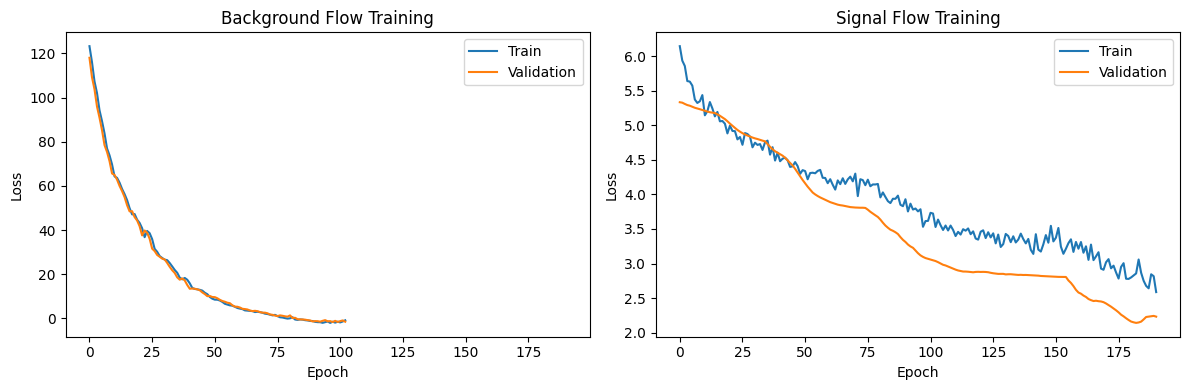

In [8]:
# Plot training curves for background and signal models
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ax[0].plot(bkg_train_losses, label="Train")
ax[0].plot(bkg_val_losses, label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Background Flow Training")
ax[0].legend()

ax[1].plot(sig_train_losses, label="Train")
ax[1].plot(sig_val_losses, label="Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Signal Flow Training")
ax[1].legend()
plt.tight_layout()
plt.show()


**Interpreting the density plot**

The histogram shows the distribution of the likelihood ratio for signal (orange) and background (blue) events. Values greater than 1 mean the signal model assigns higher density than the background model for that event, but background events can still produce \(R>1\) because the two densities overlap in feature space. What matters is the relative separation of the two curves: the farther the orange curve sits to the right of the blue one, the easier it is to choose a threshold on \(R\) that keeps signal while rejecting background. The ROC curve below quantifies that separation across all thresholds.

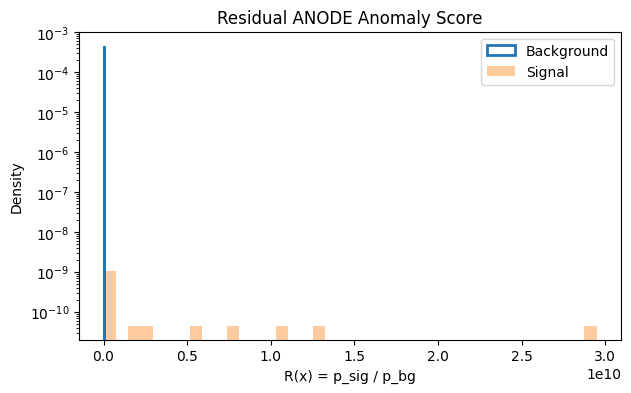

Signal efficiency at R>1: 0.967
Background efficiency at R>1: 1.000
Saved anomaly scores to /Users/krishwu/code/GBI/ranode/notebooks/anomaly_scores.csv


In [9]:
# --- evaluate anomaly scores on held-out sample ---
with torch.no_grad():
    test_shifted_tensor = torch.from_numpy(SR_test_shifted.astype("float32")).to(device)
    sig_log_prob = model_S.log_prob(
        inputs=test_shifted_tensor[:, 1:-1],
        context=test_shifted_tensor[:, 0:1],
    ).cpu().numpy()

sig_prob = np.exp(sig_log_prob)
bg_prob = np.exp(log_B_test.flatten()) * mass_pdf_test
ratio = sig_prob / (bg_prob + 1e-12)

labels = SR_test[:, -1]

plt.figure(figsize=(7, 4))
plt.hist(ratio[labels == 0], bins=40, density=True, histtype='step', linewidth=2, color='tab:blue', label='Background')
plt.hist(ratio[labels == 1], bins=40, density=True, histtype='stepfilled', alpha=0.4, color='tab:orange', label='Signal')
plt.yscale("log")
plt.xlabel("R(x) = p_sig / p_bg")
plt.ylabel("Density")
plt.legend()
plt.title("Residual ANODE Anomaly Score")
plt.show()

signal_eff = (ratio[labels == 1] > 1.0).mean()
background_eff = (ratio[labels == 0] > 1.0).mean()
print(f"Signal efficiency at R>1: {signal_eff:.3f}")
print(f"Background efficiency at R>1: {background_eff:.3f}")

score_df = pd.DataFrame(
    {
        "time_ms": SR_test[:, 0],
        "label": labels,
        "sig_prob": sig_prob,
        "bg_prob": bg_prob,
        "anomaly_ratio": ratio,
    }
)
csv_path = project_root / "notebooks" / "anomaly_scores.csv"
score_df.to_csv(csv_path, index=False)
print(f"Saved anomaly scores to {csv_path}")

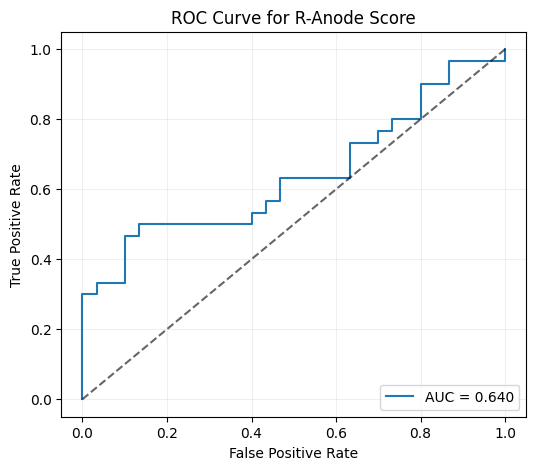

In [10]:
fpr, tpr, thresholds = roc_curve(labels, ratio)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for R-Anode Score")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.2)
plt.show()

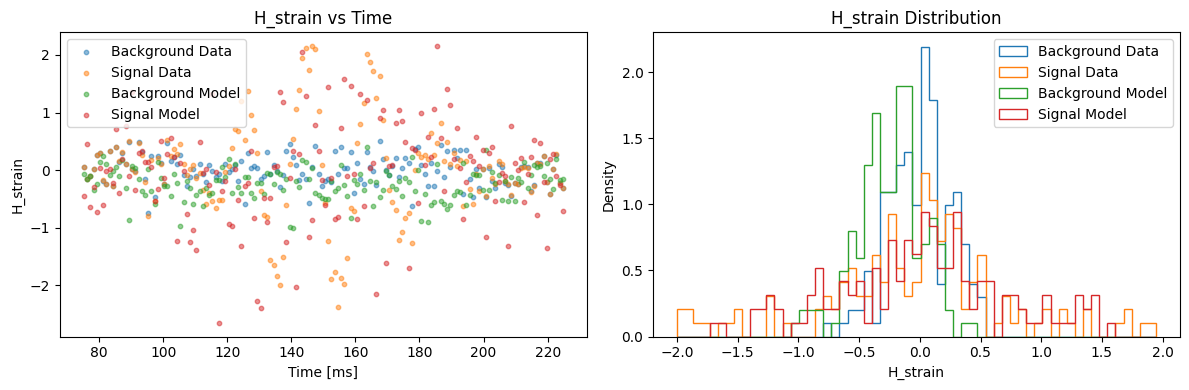

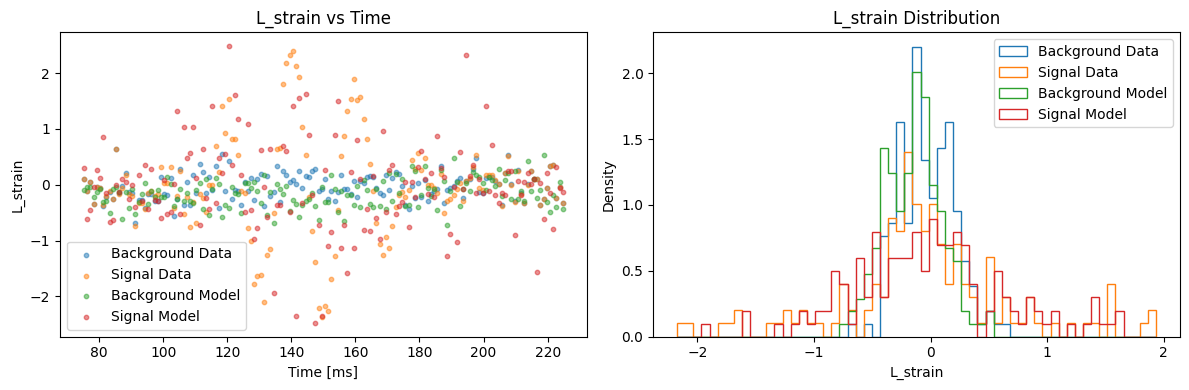

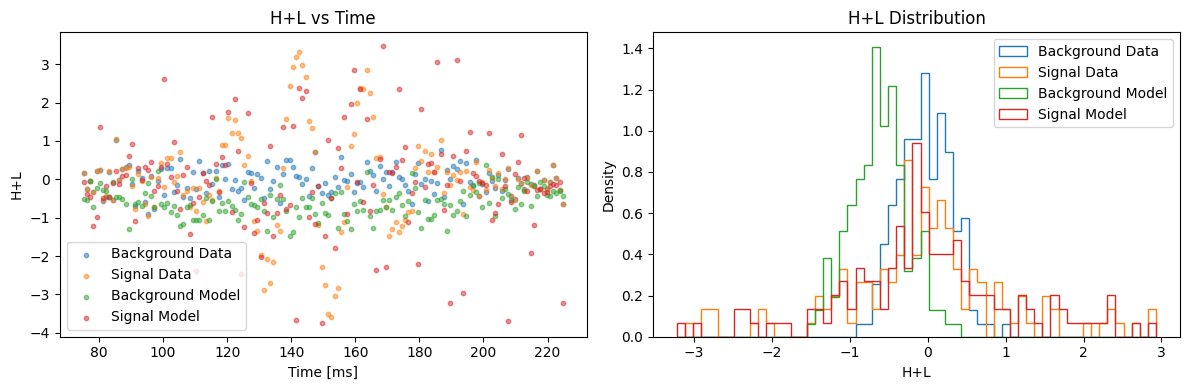

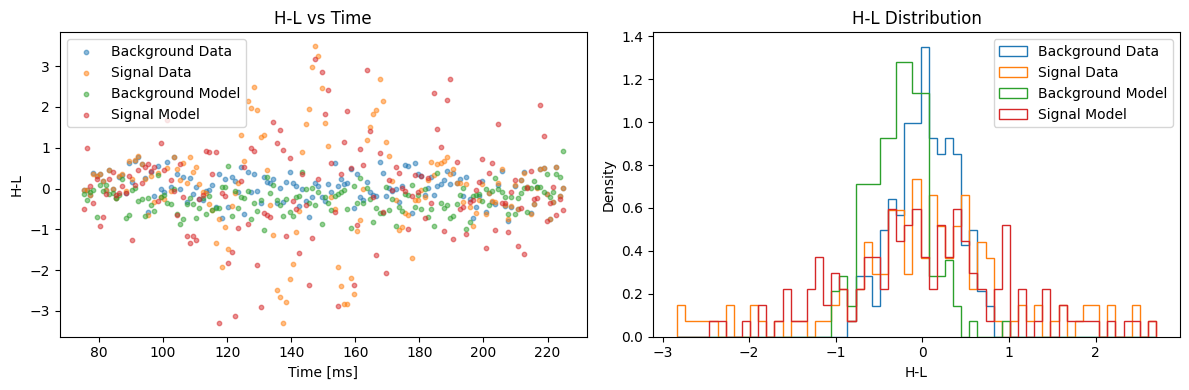

In [11]:
# --- visualize strains vs time and distributions for data vs learned models ---
def sample_subset(data: np.ndarray, max_points: int = 600, rng: np.random.Generator = np.random.default_rng()):
    if len(data) <= max_points:
        return data
    idx = rng.choice(len(data), size=max_points, replace=False)
    return data[idx]

with torch.no_grad():
    cond_inputs = torch.from_numpy(SR_bkg_aligned_raw[:, 0].astype("float32")).reshape(-1, 1).to(device)
    bg_generated = model_B.model.sample(num_samples=cond_inputs.shape[0], cond_inputs=cond_inputs).cpu().numpy()
    sig_context = torch.from_numpy(SR_sig_shifted[:, 0:1].astype("float32")).to(device)
    generated = []
    for ctx in torch.split(sig_context, 1, dim=0):
        sample = model_S.sample(num_samples=1, context=ctx).cpu().numpy()
        if sample.ndim == 3:
            sample = sample[0, 0]
        elif sample.ndim == 2:
            sample = sample[0]
        generated.append(np.asarray(sample))
    sig_generated_features = np.stack(generated, axis=0)

bg_generated_full = np.concatenate([SR_bkg_aligned_raw[:, 0:1], bg_generated, np.zeros((bg_generated.shape[0], 1))], axis=1)
bg_generated_raw = inverse_transform(bg_generated_full, pre_params)

sig_time = sig_context.cpu().numpy() + center_time
sig_generated_features = np.atleast_2d(sig_generated_features)
sig_generated_processed = np.concatenate([sig_time, sig_generated_features, np.ones((sig_generated_features.shape[0], 1))], axis=1)
sig_generated_raw = inverse_transform(sig_generated_processed, pre_params)

plot_sets = {
    "Background Data": SR_bkg_aligned_raw,
    "Signal Data": SR_sig_aligned_raw,
    "Background Model": bg_generated_raw,
    "Signal Model": sig_generated_raw,
}

feature_names = [
    ("H_strain", 1),
    ("L_strain", 2),
    ("H+L", 3),
    ("H-L", 4),
 ]

rng = np.random.default_rng(2025)
for name, idx in feature_names:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    all_values = []
    for label, dataset in plot_sets.items():
        all_values.append(dataset[:, idx])
        subset = sample_subset(dataset, max_points=600, rng=rng)
        axes[0].scatter(subset[:, 0], subset[:, idx], label=label, s=10, alpha=0.5)
    axes[0].set_xlabel("Time [ms]")
    axes[0].set_ylabel(name)
    axes[0].set_title(f"{name} vs Time")
    axes[0].legend()

    values_concat = np.concatenate(all_values)
    vmin = np.quantile(values_concat, 0.01)
    vmax = np.quantile(values_concat, 0.99)
    bins = np.linspace(vmin, vmax, 60)

    for label, dataset in plot_sets.items():
        axes[1].hist(dataset[:, idx], bins=bins, histtype="step", density=True, label=label)

    axes[1].set_xlabel(name)
    axes[1].set_ylabel("Density")
    axes[1].set_title(f"{name} Distribution")
    axes[1].legend()
    plt.tight_layout()
    plt.show()
